``` c++
  231 inline void TVector3::SetXYZ(Double_t xx, Double_t yy, Double_t zz) {
  232    fX = xx;
  233    fY = yy;
  234    fZ = zz;
  235 }
  332 inline void TLorentzVector::SetXYZT(Double_t  x, Double_t  y, Double_t  z, Double_t t) {
  333    fP.SetXYZ(x, y, z);
  334    SetT(t);
  335 }
  336 
  337 inline void TLorentzVector::SetPxPyPzE(Double_t px, Double_t py, Double_t pz, Double_t e) {
  338    SetXYZT(px, py, pz, e);
  339 }
  340 
  341 inline void TLorentzVector::SetXYZM(Double_t  x, Double_t  y, Double_t  z, Double_t m) {
  342    if ( m  >= 0 )
  343       SetXYZT( x, y, z, TMath::Sqrt(x*x+y*y+z*z+m*m) );
  344    else
  345       SetXYZT( x, y, z, TMath::Sqrt( TMath::Max((x*x+y*y+z*z-m*m), 0. ) ) );
  346 }
  347 
  348 inline void TLorentzVector::SetPtEtaPhiM(Double_t pt, Double_t eta, Double_t phi, Double_t m) {
  349    pt = TMath::Abs(pt);
  350    SetXYZM(pt*TMath::Cos(phi), pt*TMath::Sin(phi), pt*sinh(eta) ,m);
  351 }
  352 
  353 inline void TLorentzVector::SetPtEtaPhiE(Double_t pt, Double_t eta, Double_t phi, Double_t e) {
  354    pt = TMath::Abs(pt);
  355    SetXYZT(pt*TMath::Cos(phi), pt*TMath::Sin(phi), pt*sinh(eta) ,e);
```

In [32]:
import plotly
import matplotlib.pyplot as plt
import uproot3 as uproot
import awkward as ak
import numpy as np
#from tqdm.notebook import tqdm # adds progress bar 

In [47]:
def set_x_y_z_m(x, y, z, m):
    """
    set the p coordinates and mass simultaneously
    """
    if m > 0: 
        return x, y, z, np.sqrt(x**2+y**2+z**2+m**2)
    else: 
        return x, y, z, np.sqrt(np.max([x**2+y**2+z**2+m**2, 0.])) 
                                
def set_pt_eta_phi_m(pt, eta, phi, m):
    """
    construct lorentz vector associated with the generated electron
    """
    trnsvrs_mom = np.abs(pt) 
    x_comp = trnsvrs_mom*np.cos(phi)
    y_comp = trnsvrs_mom*np.sin(phi)
    z_comp = trnsvrs_mom*np.sinh(eta)
    return set_x_y_z_m(x_comp, y_comp, z_comp, m)

def set_pt_eta_phi_e(pt, eta, phi, e):
    """
    construct lorentz vector associated with the reconstructed electron
    """
    trnsvrs_mom = np.abs(pt) 
    x_comp = trnsvrs_mom*np.cos(phi)
    y_comp = trnsvrs_mom*np.sin(phi)
    z_comp = trnsvrs_mom*np.sinh(eta)
    return x_comp, y_comp, z_comp, e

def delta_r1(a, b):
    """
    given two vectors a and b, calculate the distance
    https://github.com/CoffeaTeam/coffea/blob/7dd4f863837a6319579f078c9e
    445c61d9106943/coffea/nanoevents/methods/vector.py#L66
    """
    a = np.array(a)
    b = np.array(b)
    
    delta_phi = (a - b + np.pi) % (2 * np.pi) - np.pi
    dist_vec = np.hypot(a - b, delta_phi)
    dist = np.linalg.norm(dist_vec)
    return dist


def phi(x, deg=False):
    """Return the spherical or cylindrical coordinate phi.
    Parameters
    ----------
    deg : float, optional
        Return the angle in degrees (default is radians).
    """
    phi = np.arctan2(x[1],x[0])
    return phi 

def deltaphi(a, b):
    """Return the phi angle difference, :math:`\\Delta \\phi`, with another Lorentz vector."""
    dphi = phi(a) - phi(b) 
    while dphi > np.pi:
        dphi -= 2 * np.pi
    while dphi < -np.pi:
        dphi += 2 * np.pi
    return dphi

def deltaeta(a, b):
    """Return the pseudorapidity difference, :math:`\\Delta \\eta`, with another Lorentz vector."""
    return a - b

def delta_r(a, b):
    """Return :math:`\\Delta R` the distance in (eta,phi) space with another Lorentz vector, defined as:
    :math:`\\Delta R = \\sqrt{(\\Delta \\eta)^2 + (\\Delta \\phi)^2}`
    """
    a = np.array(a)
    b = np.array(b)
    return np.linalg.norm(np.sqrt(deltaeta(a,b) ** 2 + deltaphi(a,b) ** 2))

In [68]:
ntuple = uproot.open('../hgcalNtuple_20.root')
tree = ntuple['ana/hgc']
tree.show()

event                      (no streamer)              asdtype('>u8')
lumi                       (no streamer)              asdtype('>u4')
run                        (no streamer)              asdtype('>u4')
vtx_x                      (no streamer)              asdtype('>f4')
vtx_y                      (no streamer)              asdtype('>f4')
vtx_z                      (no streamer)              asdtype('>f4')
genpart_eta                TStreamerSTL               asjagged(asdtype('>f4'), 10)
genpart_phi                TStreamerSTL               asjagged(asdtype('>f4'), 10)
genpart_pt                 TStreamerSTL               asjagged(asdtype('>f4'), 10)
genpart_energy             TStreamerSTL               asjagged(asdtype('>f4'), 10)
genpart_dvx                TStreamerSTL               asjagged(asdtype('>f4'), 10)
genpart_dvy                TStreamerSTL               asjagged(asdtype('>f4'), 10)
genpart_dvz                TStreamerSTL               asjagged(asdtype('>f4'), 10)
genpa

In [40]:
# m_electron =  0.000511
# # generated parameters are symmetric arrays
# generated_energies = np.array(list(tree['gen_energy'].array())).flatten()
# gen_pt = np.array(list(tree['gen_pt'].array())).flatten()
# gen_eta = np.array(list(tree['gen_eta'].array())).flatten()
# gen_phi = np.array(list(tree['gen_phi'].array())).flatten()
# # reco parameters are jagged
# reconstructed_energies = list(tree['rechit_energy'].array())
# rechit_pt = list(tree['rechit_pt'].array())
# rechit_eta = list(tree['rechit_eta'].array())
# rechit_phi = list(tree['rechit_phi'].array()) 
# rechit_layer = list(tree['rechit_layer'].array())


# total_e_per_evt = [] 

# for gen_idx, row_gen_e  in enumerate(generated_energies):
#     # we don't really need the energy per say
#     elect_lrntz_vec = set_pt_eta_phi_m(
#         gen_pt[gen_idx], gen_eta[gen_idx], gen_phi[gen_idx], m_electron 
#     )    
#     #print("event:", gen_idx)
    
#     summed_cone_e = 0 
    
#     for row_rec_e, row_rec_pt, row_rec_eta, row_rec_phi, row_rec_layer in zip(
#         reconstructed_energies, rechit_pt, rechit_eta, rechit_phi, rechit_layer):
        
#         for rec_idx, rechit_e in enumerate(row_rec_e):
            
#             if row_rec_layer[rec_idx] < 29: 
                
#                 rechit_pt = rechit_e/ np.cosh(row_rec_eta[rec_idx])
#                 #print(row_rec_eta[rec_idx])
#                 rechit_lrntz_vec = set_pt_eta_phi_e(
#                     rechit_pt, row_rec_eta[rec_idx], row_rec_phi[rec_idx], rechit_e
#                 ) 
                
#                 d_r = delta_r(elect_lrntz_vec[0:3],rechit_lrntz_vec[0:3])
                
#                 if d_r < 0.3:  
                    
#                     summed_cone_e += rechit_e 
    
#     total_e_per_evt.append(summed_cone_e)
    

KeyboardInterrupt: 

In [78]:
x = np.array([1,1,1])
y = np.array([1,3,1])
#delta_r1(x, y)
delta_r(x,y)

set_pt_eta_phi_e(
    rechit_pt, row_rec_eta[0], row_rec_phi[0], rechit_e
) 

(1.9574138e-06, 1.3410988e-05, -6.801729e-05, 6.6296256e-05)

In [75]:
m_electron =  0.000511
# generated parameters are symmetric arrays
generated_energies = np.array(list(tree['gen_energy'].array())).flatten()
gen_pt = np.array(list(tree['gen_pt'].array())).flatten()
gen_eta = np.array(list(tree['gen_eta'].array())).flatten()
gen_phi = np.array(list(tree['gen_phi'].array())).flatten()
# reco parameters are jagged
reconstructed_energies = list(tree['simhit_energy'].array())
#rechit_pt = list(tree['simhit_pt'].array())
rechit_eta = list(tree['simhit_eta'].array())
rechit_phi = list(tree['simhit_phi'].array()) 
rechit_layer = list(tree['simhit_layer'].array())


total_e_per_evt = [] 

for gen_idx, row_gen_e  in enumerate(generated_energies[0:10]):
    # we don't really need the energy per say
    elect_lrntz_vec = set_pt_eta_phi_m(
        gen_pt[gen_idx], gen_eta[gen_idx], gen_phi[gen_idx], m_electron 
    )    
    print("Summing event:", gen_idx)
    
    
    summed_cone_e = 0 
    for i,(row_rec_e, row_rec_eta, row_rec_phi, row_rec_layer) in enumerate(zip(
        reconstructed_energies, rechit_eta, rechit_phi, rechit_layer)):
        print("Checking Rechit: ", i)
        mask = row_rec_layer < 29
        row_rec_e = row_rec_e[mask]
        #row_rec_pt = row_rec_pt[mask]
        row_rec_eta = row_rec_eta[mask]
        row_rec_phi = row_rec_phi[mask] 
        #row_rec_pt = row_rec_pt[mask]
        
        for rec_idx, rechit_e in enumerate(row_rec_e):

            rechit_pt = rechit_e/ np.cosh(row_rec_eta[rec_idx])
            #print(row_rec_eta[rec_idx])
            rechit_lrntz_vec = set_pt_eta_phi_e(
                rechit_pt, row_rec_eta[rec_idx], row_rec_phi[rec_idx], rechit_e
            ) 

            d_r = delta_r1(elect_lrntz_vec[0:3],rechit_lrntz_vec[0:3])

            if d_r < 0.3:  
                print(d_r)
                summed_cone_e += rechit_e 
                print(summed_cone_e)
                
    total_e_per_evt.append(summed_cone_e)
    

Summing event: 0
Checking Rechit:  0
Checking Rechit:  1
Checking Rechit:  2
Checking Rechit:  3
Checking Rechit:  4
Checking Rechit:  5
Checking Rechit:  6
Checking Rechit:  7
Checking Rechit:  8
Checking Rechit:  9
Checking Rechit:  10
Checking Rechit:  11
Checking Rechit:  12
Checking Rechit:  13
Checking Rechit:  14
Checking Rechit:  15
Checking Rechit:  16
Checking Rechit:  17
Checking Rechit:  18
Checking Rechit:  19
Checking Rechit:  20
Checking Rechit:  21
Checking Rechit:  22
Checking Rechit:  23
Checking Rechit:  24
Checking Rechit:  25
Checking Rechit:  26
Checking Rechit:  27
Checking Rechit:  28
Checking Rechit:  29
Checking Rechit:  30
Checking Rechit:  31
Checking Rechit:  32
Checking Rechit:  33
Checking Rechit:  34
Checking Rechit:  35
Checking Rechit:  36
Checking Rechit:  37
Checking Rechit:  38
Checking Rechit:  39
Checking Rechit:  40
Checking Rechit:  41
Checking Rechit:  42
Checking Rechit:  43
Checking Rechit:  44
Checking Rechit:  45
Checking Rechit:  46
Checki

Checking Rechit:  378
Checking Rechit:  379
Checking Rechit:  380
Checking Rechit:  381
Checking Rechit:  382
Checking Rechit:  383
Checking Rechit:  384
Checking Rechit:  385
Checking Rechit:  386
Checking Rechit:  387
Checking Rechit:  388
Checking Rechit:  389
Checking Rechit:  390
Checking Rechit:  391
Checking Rechit:  392
Checking Rechit:  393
Checking Rechit:  394
Checking Rechit:  395
Checking Rechit:  396
Checking Rechit:  397
Checking Rechit:  398
Checking Rechit:  399
Checking Rechit:  400
Checking Rechit:  401
Checking Rechit:  402
Checking Rechit:  403
Checking Rechit:  404
Checking Rechit:  405
Checking Rechit:  406
Checking Rechit:  407
Checking Rechit:  408
Checking Rechit:  409
Checking Rechit:  410
Checking Rechit:  411
Checking Rechit:  412
Checking Rechit:  413
Checking Rechit:  414
Checking Rechit:  415
Checking Rechit:  416
Checking Rechit:  417
Checking Rechit:  418
Checking Rechit:  419
Checking Rechit:  420
Checking Rechit:  421
Checking Rechit:  422
Checking R

Checking Rechit:  753
Checking Rechit:  754
Checking Rechit:  755
Checking Rechit:  756
Checking Rechit:  757
Checking Rechit:  758
Checking Rechit:  759
Checking Rechit:  760
Checking Rechit:  761
Checking Rechit:  762
Checking Rechit:  763
Checking Rechit:  764
Checking Rechit:  765
Checking Rechit:  766
Checking Rechit:  767
Checking Rechit:  768
Checking Rechit:  769
Checking Rechit:  770
Checking Rechit:  771
Checking Rechit:  772
Checking Rechit:  773
Checking Rechit:  774
Checking Rechit:  775
Checking Rechit:  776
Checking Rechit:  777
Checking Rechit:  778
Checking Rechit:  779
Checking Rechit:  780
Checking Rechit:  781
Checking Rechit:  782
Checking Rechit:  783
Checking Rechit:  784
Checking Rechit:  785
Checking Rechit:  786
Checking Rechit:  787
Checking Rechit:  788
Checking Rechit:  789
Checking Rechit:  790
Checking Rechit:  791
Checking Rechit:  792
Checking Rechit:  793
Checking Rechit:  794
Checking Rechit:  795
Checking Rechit:  796
Checking Rechit:  797
Checking R

KeyboardInterrupt: 

In [74]:
reconstructed_energies = list(tree['simhit_energy'].array()) 
# #print(reconstructed_energies)
# #len(reconstructed_energies)
# len(generated_energies)
# for element in reconstructed_energies:
#     print(element.size)
    
# print(len(reconstructed_energies))
print(len(generated_energies))

2000


In [49]:

reconstructed_energies = list(tree['rechit_layer'].array())
#print(reconstructed_energies)
#len(reconstructed_energies)
len(generated_energies)
for element in reconstructed_energies:
    if (element.size == 39106 ):
        print(element.size)

In [52]:
generated_energies[0:4]

array([1000.0097, 1000.0097,  999.9904,  999.9904], dtype=float32)

In [67]:
# list(tree['rechit_energy'].array())

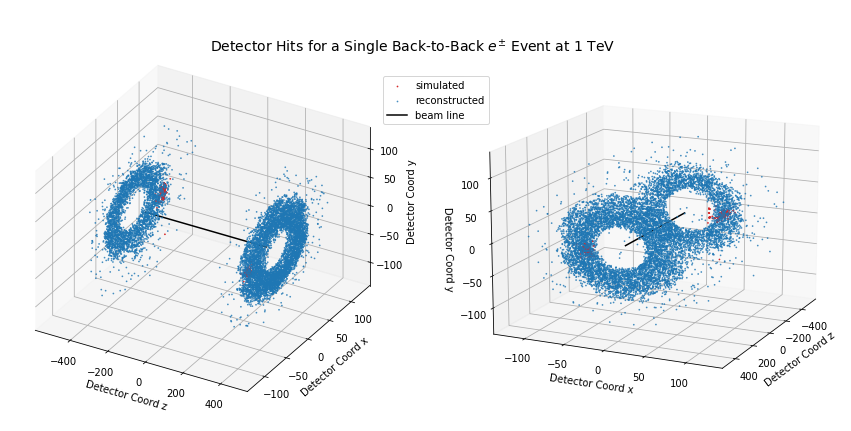

In [69]:
# Note, it is easier to visualize (x, y, z) --> (z, x, y) 
evt_num = 100
fig = plt.figure(figsize=(15,12))
fig.suptitle(r"Detector Hits for a Single Back-to-Back $e^{\pm}$ Event at 1 TeV", y = .73, size = 14)

for panel in range (121,123):
    ax = fig.add_subplot(panel, projection='3d')
    ax.scatter(tree['simhit_z'].array()[evt_num], 
               tree['simhit_x'].array()[evt_num], 
               tree['simhit_y'].array()[evt_num],
               label = "simulated",
               color = "tab:red", 
               alpha = 1,
               s = .50)
    mask = np.in1d(tree['rechit_z'].array()[evt_num], tree['simhit_z'].array()[evt_num], invert = True) 
    ax.scatter(tree['rechit_z'].array()[evt_num][mask], 
               tree['rechit_x'].array()[evt_num][mask], 
               tree['rechit_y'].array()[evt_num][mask],
               label = "reconstructed",
               color = "tab:blue",
               alpha = .75,
               s = .55)
    ax.plot([-320., 320.], [0,0], [0,0], color='k', label = "beam line") 
    ax.set_xlabel('Detector Coord z')
    ax.set_ylabel('Detector Coord x')
    ax.set_zlabel('Detector Coord y')
    if panel == 121: 
        ax.set_proj_type('ortho')
    else: 
        ax.view_init(15, 25)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc=(.45, .71))